In [106]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import scipy.stats as ss
import warnings
from datetime import datetime
from scipy.optimize import minimize
import scipy.special as ss
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("Merged_data.csv")

In [3]:
df["moving_average_HLC"] = (df["High"] + df["Low"] + df ["Close "]) /3

In [4]:
df.head()

,Date,Open,Close,High,Low,Volume,ADS_Index,Mkt-RF,SMB,HML,RF,Returns,SP500,Open_Close,High_Low,HLOC,EWM_OpenClose,moving_average_HLC
0,2016-01-06,623.77,635.20,639.79,618.64,40167,-0.308089,-1.35,-0.12,0.00,0.0,-0.005036,1990.26,629.485,629.215,629.3500,629.485000,631.210000
1,2016-01-07,620.55,606.00,630.00,605.21,54784,-0.294335,-2.44,-0.29,0.08,0.0,-0.001800,1943.09,613.275,617.605,615.4400,624.081667,613.736667
2,2016-01-08,617.05,608.36,624.14,606.00,42130,-0.281488,-1.11,-0.47,-0.03,0.0,-0.039841,1922.03,612.705,615.070,613.8875,620.289444,612.833333
3,2016-01-11,612.00,617.51,619.85,598.57,75915,-0.248493,-0.06,-0.65,0.34,0.0,-0.001465,1923.67,614.755,609.210,611.9825,618.444630,611.976667
4,2016-01-12,620.84,619.28,625.99,612.24,36843,-0.239263,0.71,-0.40,-0.77,0.0,0.017457,1938.68,620.060,619.115,619.5875,618.983086,619.170000


In [5]:
window=100
T=300
num_boot=1000 #keep changing this value so you get the least rmse
Y

**EMA Bootstrap**

In [49]:
def EMA_train(X, Y):
    T= Y.shape[0]        
#     X = np.column_stack([np.ones((T,1)),X])
    N = X.shape        
    invXTX = np.linalg.inv(X.transpose()@X)
    beta_hat = invXTX@X.transpose()@Y
    y_hat = X@beta_hat
    
    return beta_hat, y_hat

In [50]:
def bootstrap():
    N = df.shape[0] # total num days
#     num_boot = 100 # total num bootstrap
#     T= 250 # start day
#     window = 200
    
    Y =df['Open '][-(N-(T+1)):].values
    Y_close = df['Close '][-(N-(T+1)):].values
    
    y_hat_ema = np.zeros(N-(T+1))
    
    for t in range(T+1, N):    
        # training data
        X_train = df[['EWM_OpenClose']][t-window:t-1] # regression variables
        X_train = np.column_stack([np.ones((len(X_train),1)),X_train])
        Y_train = df['Open '][t-window:t-1].values
        # one day prediction
        X_pred = df[['EWM_OpenClose']][t-1:t]
        X_pred = np.column_stack([np.ones((len(X_pred),1)),X_pred])
        
        yhat_train = EMA_train(X_train, Y_train)[1]
        
        res_train =  Y_train - yhat_train
        y_pred_all = np.zeros(num_boot)
        # bootstrap method: switching residuals
        for i in range(0, num_boot):
            err = np.random.choice(res_train, (window-1, ), replace=True)
            y_bstr = yhat_train + err   
            beta_bstr = EMA_train(X_train, y_bstr)[0]
            y_pred_bstr = X_pred@beta_bstr
            y_pred_all[i]=y_pred_bstr         
        y_pred_ema1 = y_pred_all.mean() # get mean of all bootstrap predictions        
        y_hat_ema[t-(T+1)]=y_pred_ema1 # do this for each time step
    rmse_ema = np.sqrt(np.mean((y_hat_ema-Y)**2))
    print(rmse_ema)
    
    
    return rmse_ema,y_hat_ema

In [51]:
rmse_ema,y_hat_ema=bootstrap()

22.63194471689258


**Moving Average of High low and close with ads index Bootstrap**

In [60]:
def MA_HL(X,Y):
    df["moving_average_HLC"] = (df["High"] + df["Low"] + df ["Close "]) /3
    
    invXTX=np.linalg.inv(X.transpose()@X)
    beta_hat = invXTX@X.transpose()@Y
    y_hat = X@beta_hat
    return beta_hat, y_hat

In [61]:
def bootstrap_MA_HL():
    N = df.shape[0] # total num days
#     num_boot = 100 # total num bootstrap
#     T= 250 # start day
#     window = 200
    Y =df['Open '][-(N-(T+1)):].values
    Y_close = df['Close '][-(N-(T+1)):].values
#     X =df[['moving_average_HLC','ADS_Index']].as_matrix()
    y_hat_MA = np.zeros(N-(T+1))
    
    for t in range(T+1, N):    
        # training data
        X_train = df[['moving_average_HLC','ADS_Index']][t-window:t-1] # regression variables
        X_train = np.column_stack([np.ones((len(X_train),1)),X_train])
        Y_train = df['Open '][t-window:t-1].values
        # one day prediction
        X_pred = df[['moving_average_HLC','ADS_Index']][t-1:t]
        X_pred = np.column_stack([np.ones((len(X_pred),1)),X_pred])
        
        yhat_train = MA_HL(X_train,Y_train)[1]
        
        res_train =  Y_train - yhat_train
        y_pred_all = np.zeros(num_boot)
        # bootstrap method: switching residuals
        for i in range(0, num_boot):
            err = np.random.choice(res_train, (window-1, ), replace=True)
            y_bstr = yhat_train + err   
            beta_bstr = EMA_train(X_train, y_bstr)[0]
            y_pred_bstr = X_pred@beta_bstr
            y_pred_all[i]=y_pred_bstr         
        y_hat_MA1 = y_pred_all.mean() # get mean of all bootstrap predictions        
        y_hat_MA[t-(T+1)]=y_hat_MA1 # do this for each time step
    rmse_MA = np.sqrt(np.mean((y_hat_MA-Y)**2))
    print(rmse_MA)
    return rmse_MA,y_hat_MA

In [62]:
rmse_MA,y_hat_MA=bootstrap_MA_HL()

11.13442616747588


**AR With All Factors Bootstrap**

In [63]:
def ARF(X,Y):
#     X = df[['High','Low','Close ','Mkt-RF','SMB','HML','ADS_Index']].as_matrix()
    invXX = np.linalg.inv(X.transpose()@X)
    beta_hat = invXX@X.transpose()@Y
    Y_HAT = X@beta_hat
    return beta_hat, Y_HAT

In [64]:
def bootstrap_ARF():
    N = df.shape[0] # total num days
#     num_boot = 100 # total num bootstrap
#     T= 250 # start day
#     window = 200
    Y =df['Open '][-(N-(T+1)):].values
    Y_close = df['Close '][-(N-(T+1)):].values
    
    y_hat_ar = np.zeros(N-(T+1))
    
    for t in range(T+1, N):    
        # training data
        X_train = df[['High','Low','Close ','Mkt-RF','SMB','HML','ADS_Index']][t-window:t-1] # regression variables
        X_train = np.column_stack([np.ones((len(X_train),1)),X_train])
        Y_train = df['Open '][t-window:t-1].values
        # one day prediction
        X_pred = df[['High','Low','Close ','Mkt-RF','SMB','HML','ADS_Index']][t-1:t]
        X_pred = np.column_stack([np.ones((len(X_pred),1)),X_pred])
        
        yhat_train = ARF(X_train, Y_train)[1]
        
        res_train =  Y_train - yhat_train
        y_pred_all = np.zeros(num_boot)
        # bootstrap method: switching residuals
        for i in range(0, num_boot):
            err = np.random.choice(res_train, (window-1, ), replace=True)
            y_bstr = yhat_train + err   
            beta_bstr = EMA_train(X_train, y_bstr)[0]
            y_pred_bstr = X_pred@beta_bstr
            y_pred_all[i]=y_pred_bstr         
        y_pred_ar1 = y_pred_all.mean() # get mean of all bootstrap predictions        
        y_hat_ar[t-(T+1)]=y_pred_ar1 # do this for each time step
    rmse_ar = np.sqrt(np.mean((y_hat_ar-Y)**2))
    print(rmse_ar)
    
    return rmse_ar,y_hat_ar

In [65]:
rmse_ar,y_hat_ar=bootstrap_ARF()

21.36887934682682


**FAMA FRENCH 5 FACTOR MODEL**

In [15]:
def FAMA(X,Y):
#     X = df[['Mkt-RF','SMB','HML','HLOC','Close ']].as_matrix()
    invXX = np.linalg.inv(X.transpose()@X)
    beta_hat = invXX@X.transpose()@Y
    Y_HAT = X@beta_hat
    return beta_hat, Y_HAT

In [16]:
def bootstrap_FAMA():
    N = df.shape[0] # total num days
#     num_boot = 100 # total num bootstrap
#     T= 250 # start day
#     window = 200
    Y =df['Open '][-(N-(T+1)):].values
    Y_close = df['Close '][-(N-(T+1)):].values
    
    y_hat_fama = np.zeros(N-(T+1))
    
    for t in range(T+1, N):    
        # training data
        X_train = df[['Mkt-RF','SMB','HML','HLOC','Close ']][t-window:t-1] # regression variables
        X_train = np.column_stack([np.ones((len(X_train),1)),X_train])
        Y_train = df['Open '][t-window:t-1].values
        # one day prediction
        X_pred = df[['Mkt-RF','SMB','HML','HLOC','Close ']][t-1:t]
        X_pred = np.column_stack([np.ones((len(X_pred),1)),X_pred])
        
        yhat_train = FAMA(X_train, Y_train)[1]
        
        res_train =  Y_train - yhat_train
        y_pred_all = np.zeros(num_boot)
        # bootstrap method: switching residuals
        for i in range(0, num_boot):
            err = np.random.choice(res_train, (window-1, ), replace=True)
            y_bstr = yhat_train + err   
            beta_bstr = EMA_train(X_train, y_bstr)[0]
            y_pred_bstr = X_pred@beta_bstr
            y_pred_all[i]=y_pred_bstr         
        y_hat_fama1 = y_pred_all.mean() # get mean of all bootstrap predictions        
        y_hat_fama[t-(T+1)]=y_hat_fama1 # do this for each time step
    rmse_fama = np.sqrt(np.mean((y_hat_fama-Y)**2))
    print(rmse_fama)
    
    return rmse_fama,y_hat_fama

In [17]:
rmse_fama,y_hat_fama=bootstrap_FAMA()

20.889476120032356


**MACD**

In [99]:
exp1 = df.Open_Close.ewm(span=12, adjust=False).mean()
exp2 = df.Open_Close.ewm(span=26, adjust=False).mean()
X=exp1-exp2

In [100]:
def MACD(X,Y):
    T=X.shape[0]
#     X = np.column_stack([np.ones((T,1)),X])
    invXX = np.linalg.inv(X.transpose()@X)
    beta_hat = invXX@X.transpose()@Y
    Y_HAT = X@beta_hat
    
    return beta_hat, Y_HAT

In [102]:
def bootstrap_MACD():
    N = df.shape[0] # total num days
#     num_boot = 100 # total num bootstrap
#     T= 250 # start day
#     window = 200
    Y =df['Open '][-(N-(T+1)):].values
    Y_close = df['Close '][-(N-(T+1)):].values
    
    y_hat_macd = np.zeros(N-(T+1))
    
    for t in range(T+1, N):    
        # training data
        X_train = df.Open_Close.ewm(span=5, adjust=False).mean()[t-window:t-1] # regression variables
        X_train = np.column_stack([np.ones((len(X_train),1)),X_train])
        Y_train = df['Open '][t-window:t-1].values
        # one day prediction
        X_pred = df.Open_Close.ewm(span=5, adjust=False).mean()[t-1:t]
        X_pred = np.column_stack([np.ones((len(X_pred),1)),X_pred])
        
        yhat_train = MACD(X_train, Y_train)[1]
        
        res_train =  Y_train - yhat_train
        y_pred_all = np.zeros(num_boot)
        # bootstrap method: switching residuals
        for i in range(0, num_boot):
            err = np.random.choice(res_train, (window-1, ), replace=True)
            y_bstr = yhat_train + err   
            beta_bstr = EMA_train(X_train, y_bstr)[0]
            y_pred_bstr = X_pred@beta_bstr
            y_pred_all[i]=y_pred_bstr         
        y_hat_macd1 = y_pred_all.mean() # get mean of all bootstrap predictions        
        y_hat_macd[t-(T+1)]=y_hat_macd1 # do this for each time step
    rmse_macd = np.sqrt(np.mean((y_hat_macd-Y)**2))
    print(rmse_macd)
    
    return rmse_macd,y_hat_macd

In [103]:
rmse_macd,y_hat_macd=bootstrap_MACD()

22.63192950346692


In [104]:
def random_forest():
    rmse_ema,y_hat_ema=bootstrap()
    rmse_MA,y_hat_MA=bootstrap_MA_HL()
    rmse_ar,y_hat_ar=bootstrap_ARF()
    rmse_fama,y_hat_fama=bootstrap_FAMA()
    rmse_macd,y_hat_macd=bootstrap_MACD()
    N = df.shape[0]
    
    Y =df['Open '][-(N-(T+1)):].values
    T1=Y.shape[0]
    Y_close = df['Close '][-(N-(T+1)):].values
    
    
    
    
    Y_rf = np.zeros(T1)
    for t in range(0, T1):
        if min(abs(y_hat_ema[t]-Y[t]),abs(y_hat_MA[t]-Y[t]),abs(y_hat_ar[t]-Y[t]),
               abs(y_hat_fama[t]-Y[t]),abs(y_hat_macd[t]-Y[t]))==abs(y_hat_ema[t]-Y[t]):
            Y_rf[t] = y_hat_ema[t]
        elif min(abs(y_hat_MA[t]-Y[t]),abs(y_hat_ema[t]-Y[t]),abs(y_hat_ar[t]-Y[t]),
                 abs(y_hat_fama[t]-Y[t]),abs(y_hat_macd[t]-Y[t]))==abs(y_hat_MA[t]-Y[t]):
            Y_rf[t] = y_hat_MA[t]
        elif min(abs(y_hat_ar[t]-Y[t]),abs(y_hat_MA[t]-Y[t]),abs(y_hat_ema[t]-Y[t]),
                 abs(y_hat_fama[t]-Y[t]),abs(y_hat_macd[t]-Y[t]))==abs(y_hat_ar[t]-Y[t]):
            Y_rf[t] = y_hat_ar[t]
        elif min(abs(y_hat_fama[t]-Y[t]),abs(y_hat_ema[t]-Y[t]),abs(y_hat_ar[t]-Y[t]),
                 abs(y_hat_MA[t]-Y[t]),abs(y_hat_macd[t]-Y[t]))==abs(y_hat_fama[t]-Y[t]):
            Y_rf[t] = y_hat_fama[t]
        else:
            Y_rf[t] = y_hat_macd[t]
            
    rmse_rf=np.sqrt(np.mean((Y-Y_rf)**2))
    print("EMA_RMSE: ", rmse_ema)
    print("MA_RMSE: ", rmse_MA)
    print("FAMA_RMSE: ", rmse_fama)
    print("AR_RMSE: ", rmse_ar)
    print("MACD_RMSE: ", rmse_macd)
    print("random forest rmse: ", rmse_rf)
    
    timevec = np.linspace(1,T1,T1)
    plt.figure(figsize=(30,20))
    
    ax = plt.subplot(211)
    ax.plot(timevec, Y, 'blue', label = "Y: original")
    ax.plot(timevec, y_hat_MA, 'red', label = "Moving Average")
    ax.plot(timevec, y_hat_ar, 'green', label = "Auto Regression")
    ax.plot(timevec, y_hat_ema, 'purple', label = "EMA")
    ax.plot(timevec, y_hat_fama, 'orange', label = "FAMA French")
    ax.plot(timevec, y_hat_macd, 'purple', label = "MACD")
    plt.title('Models Prediction using single models')
    ax.legend(loc=2, bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
    
    
    ax = plt.subplot(212)
    ax.plot(timevec, Y, 'blue', label = "Y: original")
    ax.plot(timevec, Y_rf, 'red', label = "Y_rf")
    plt.title('Random Forest Prediction')
    ax.legend(loc=2, bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
    plt.show()
    return rmse_rf,Y,Y_rf,Y_close

22.622856236990227
11.141944295725576
21.366689307993067
20.886137349882045
22.6232632188954
EMA_RMSE:  22.622856236990227
MA_RMSE:  11.141944295725576
FAMA_RMSE:  20.886137349882045
AR_RMSE:  21.366689307993067
MACD_RMSE:  22.6232632188954
random forest rmse:  8.907226885909285


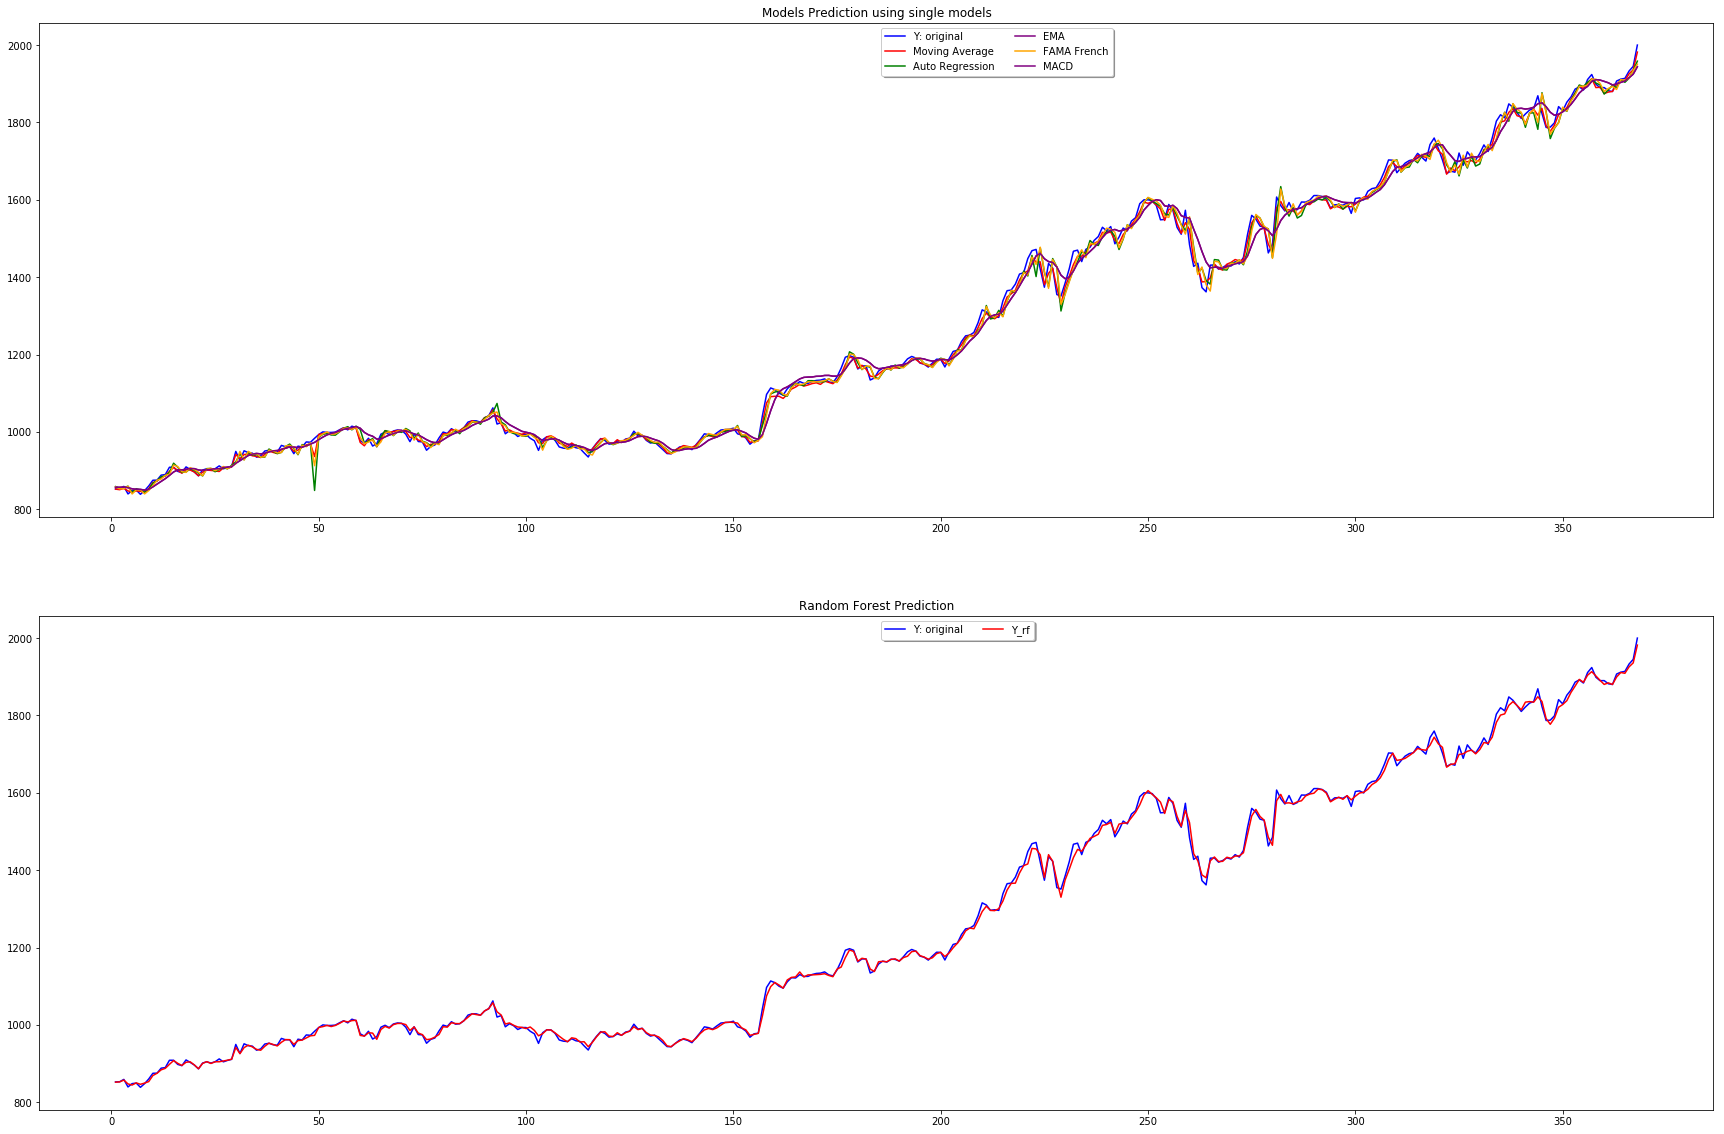

8.907226885909285

In [105]:
rmse_rf,Y,Y_rf,Y_close=random_forest()
rmse_rf

In [77]:
rmse_rf

8.918259361592542

In [78]:
merge= np.stack([Y,Y_rf,Y_close],axis=1)

In [79]:
RF=pd.DataFrame(merge,columns=['Y','Y_rf','Y_close'])

In [80]:
RF= RF.reindex()

In [81]:
RF.to_csv("RF.csv",index=False)

In [82]:
RF.shape

(368, 3)

In [83]:
RF.head()

,Y,Y_rf,Y_close
0,852.52,851.936496,852.69
1,852.96,852.672856,856.70
2,859.00,857.201191,841.80
3,839.50,847.289339,848.30
4,848.11,844.518777,847.75


In [ ]:
    print("EMA_RMSE: ", rmse_ema)
    print("MA_RMSE: ", rmse_MA)
    print("FAMA_RMSE: ", rmse_fama)
    print("AR_RMSE: ", rmse_ar)
    print("MACD_RMSE: ", rmse_macd)
    print("random forest rmse: ", rmse_rf)
    
    timevec = np.linspace(1,T1,T1)
    plt.figure(figsize=(30,20))
    
    ax = plt.subplot(211)
    ax.plot(timevec, Y, 'blue', label = "Y: original")
    ax.plot(timevec, y_hat_MA, 'red', label = "Moving Average")
    ax.plot(timevec, y_hat_ar, 'green', label = "Auto Regression")
    ax.plot(timevec, y_hat_ema, 'purple', label = "EMA")
    ax.plot(timevec, y_hat_fama, 'orange', label = "FAMA French")
    ax.plot(timevec, y_hat_macd, 'purple', label = "MACD")
    plt.title('Models Prediction using single models')
    ax.legend(loc=2, bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
    
    
    ax = plt.subplot(212)
    ax.plot(timevec, Y, 'blue', label = "Y: original")
    ax.plot(timevec, Y_rf, 'red', label = "Y_rf")
    plt.title('Random Forest Prediction')
    ax.legend(loc=2, bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
    plt.show()